### TP made in pair: Mariana OLM REZENDE and Luiz Fernando MOREIRA

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Loading the data

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

label is 6


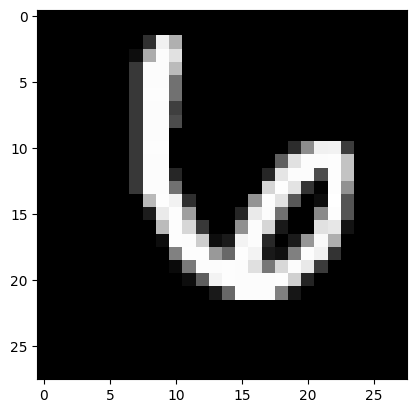

In [5]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [6]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digits (InputLayer)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([2, 9, 9, 3, 3, 2, 2, 2, 2, 9, 2, 3, 9, 9, 2, 9, 2, 9, 9, 4, 9, 3,
       2, 3, 9, 9, 3, 9, 9, 2])

In [8]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities. 

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

- loss function of the untrained model
- gradient of this loss (with respect to each weight in the network)
  
The backpropagation algorithm works by computing the error between the predicted output and the actual output for each training example, and then propagating this error back through the layers of the network to adjust the weights. The process is repeated for multiple iterations until the weights converge to a point where the error is minimized.

In [9]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
    # Run the forward pass of the layer.
    # The operations that the layer applies
    # to its inputs are going to be recorded
    # on the GradientTape.
    
    logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)
    
    # Compute the loss value for this minibatch.
    loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [10]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]
        
    model.set_weights(new_weights)

# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [11]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

np.float32(2.349539)

#### **Question 4.1: How many optimization variables are we going to train using this model?** 

**R:** 26,506

# Training the model

#### **Question 5.1: Using the helper code, implement stochastic gradient descent.** 

In [27]:
# Stochastic gradient algorithm

def SGD(model, x_train, y_train, learning_rate, epochs, batch_size):
    num_samples = x_train.shape[0]
    loss_list = []
    n_computation = []
    
    computation_count = 0

    for epoch in range(epochs):
        for i, batch_start in enumerate(range(0, num_samples, batch_size)):  
            
            initial_lr = learning_rate / np.sqrt(i + 1)
            
            # Selecting the batch
            x_train_batch = x_train[batch_start: batch_start + batch_size]
            y_train_batch = y_train[batch_start: batch_start + batch_size]
        
            # Forward Pass
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)  # Predictions
                
                loss_value = loss(y_train_batch, logits)  # Compute loss
            
            # Compute gradient
            grad = tape.gradient(loss_value, model.trainable_weights)
        
            update_weights(model, grad, real_factor=-initial_lr)  # Standard SGD

            # Record loss every 10 iterations
            if computation_count % 10 == 0:
                loss_list.append(mean_loss(model, x_train, y_train))
                n_computation.append(computation_count)

            computation_count += 1

    return loss_list, n_computation

#### **Question 5.2: Run it for one pass over the data (also called one epoch) and with a step size that satisfies the conditions required by theory.** 

**R:** According to the theory, the best theoretical learning rate can be obtained as:

**$$\gamma_k = \frac{\gamma_0}{\sqrt{k+1}}$$**

That was implemented at each iteration $k$ of the algorithm.

In [24]:
# initialize model
model = build_model()

initial_learning_rate = 0.01

# run SGD 
run_sgd = SGD(model, x_train, y_train, initial_learning_rate, epochs=1, batch_size=100)[0]

In [25]:
# Returns the list of losses (i % 50 == 0)
run_sgd

[np.float32(2.1959975),
 np.float32(1.3338737),
 np.float32(0.96427065),
 np.float32(0.787508),
 np.float32(0.66281444),
 np.float32(0.58310646),
 np.float32(0.532249),
 np.float32(0.51818436),
 np.float32(0.4977868),
 np.float32(0.47729784),
 np.float32(0.44637358),
 np.float32(0.42956463),
 np.float32(0.43384632),
 np.float32(0.45297056),
 np.float32(0.409661),
 np.float32(0.38958162),
 np.float32(0.3878941),
 np.float32(0.37708884),
 np.float32(0.37580112),
 np.float32(0.3687981),
 np.float32(0.3815117),
 np.float32(0.3603255),
 np.float32(0.35189006),
 np.float32(0.36098972),
 np.float32(0.3454515),
 np.float32(0.34120238),
 np.float32(0.34347898),
 np.float32(0.3395548),
 np.float32(0.33465844),
 np.float32(0.32621935),
 np.float32(0.33648115),
 np.float32(0.32746822),
 np.float32(0.32451153),
 np.float32(0.31906387),
 np.float32(0.3178005),
 np.float32(0.31768143),
 np.float32(0.3236352),
 np.float32(0.3414123),
 np.float32(0.30997157),
 np.float32(0.3038566),
 np.float32(0.30591

#### **Question 5.2: Plot the objective value as a function of the iterations. Compare different step size choices.**

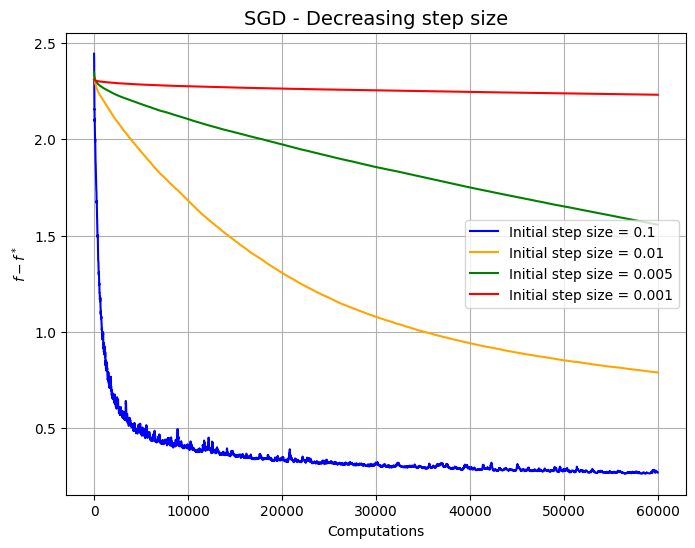

In [14]:
plt.figure(figsize=(8, 6))

learning_rates = [0.1, 0.01, 0.005, 0.001]
colors = ['blue', 'orange', 'green', 'red']

for lr, color in zip(learning_rates, colors):
    model = build_model()  

    loss_list, n_computation = SGD(model, x_train, y_train, lr, epochs=1, batch_size=1)

    plt.plot(n_computation, loss_list,label=f"Initial step size = {lr}", color=color)

plt.xlabel("Computations")
plt.ylabel(r"$f - f^*$")
plt.title("SGD - Decreasing step size", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

#### **DISCLAIMER:** Running the cell above takes too long because there are 5 SGDs, each one with 60,000 iterations. This was the result:

<img src="Q5-2.png" alt="Alt text" width="600" height="350">

#### **Question 5.2: What do you observe?**

**R:** In this case, we ran 1 epoch with a batch size of 1 $(60000$ iterations) with a decreasing learning rate (step size). Plotting the object value for 4 different values of initial step size, we can observe that:
* **$\gamma_k = 0.1$ (blue curve):**
This step size results in the fastest convergence. The objective value decreases rapidly and stabilizes at a lower value, indicating that the algorithm efficiently reaches a good local minimum.
* **$\gamma_k = 0.01$ (orange curve):**
The convergence is slower than with $\gamma_k = 0.1$, but the objective value continues to decrease smoothly. This step size balances stability and progress but takes longer to reach a low value.
* **$\gamma_k = 0.005$ (green curve):**
The convergence is even slower compared to $\gamma_k = 0.01$. The curve suggests that the algorithm is progressing toward a local minimum, but at a much slower rate.
* **$\gamma_k = 0.001$ (red curve):**
With this small step size, the algorithm struggles to make significant progress within 1 epoch. The objective value decreases very gradually, showing that the updates are too small for efficient convergence.

# Empirical risk minimization

#### **Question 6.1: Run stochastic gradient descent for 5 epochs and compare.**

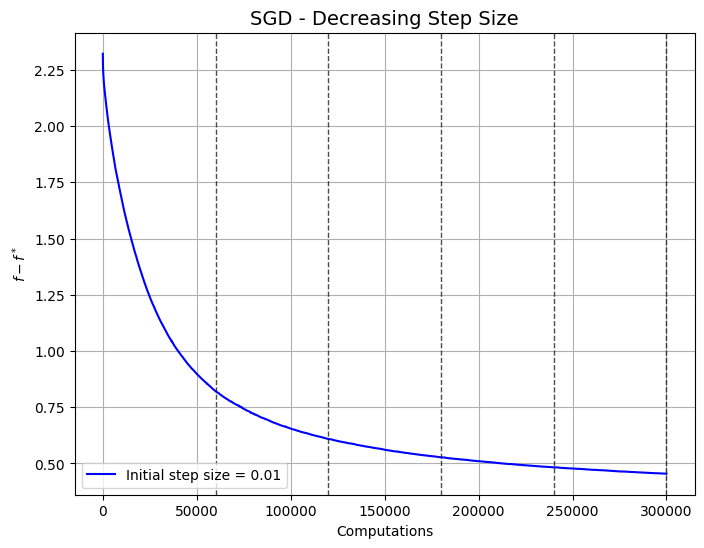

In [16]:
plt.figure(figsize=(8, 6))

learning_rate = 0.01

model = build_model()  

# Run SGD with multiple epochs
epochs = 5
batch_size = 1
loss_list, n_computation = SGD(model, x_train, y_train, learning_rate, epochs=epochs, batch_size=batch_size)

#### **DISCLAIMER:** Running the cell above takes too long because there are 300,000 iterations. This was the result:

<img src="Q6-1.png" alt="Alt text" width="600" height="350">

#### **Question 6.2: According to you, what is the advantage of such a scheme?**

**R:** This formula represents a mini-batch gradient update:
$$\theta_{k+1} = \theta_k - \frac{\gamma_k}{B} \sum_{i \in b_{k+1}} \nabla \ell(\Phi_{\theta_k}(x_i), y_i^{\text{true}})$$

Running stochastic gradient descent (SGD) for 5 epochs allowed the model with a step size of 0.01 to converge to a better solution, potentially reaching a minimum close to the global optimum. However, when using a batch size of 1, the process was significantly slower and inefficient, making convergence much more time-consuming.

Besides that, if the batch size had other value, it would have scaled the gradient updates proportionally to the batch size, which could lead to unstable learning. The new approach normalizes the step size by dividing the gradient update by $B$, ensuring that training remains stable and efficient regardless of the batch size used.

#### **Question 6.3: Implement mini-batch stochastic gradient descent and compare**
**R:** Mini-batch stochastic gradient descent computes gradients on small random subsets of the dataset rather than the entire dataset (as in batch gradient descent) or a single sample at a time (as in standard SGD). The main advantage of this approach is that it improves computational efficiency. It also provides a balance between speed and stability.

In our implementation, we used a batch size of 32, which significantly improved the training speed compared to the case where the batch size was 1. The larger batch size allowed for more efficient updates while still maintaining some level of stochasticity, leading to faster convergence without sacrificing too much generalization performance.

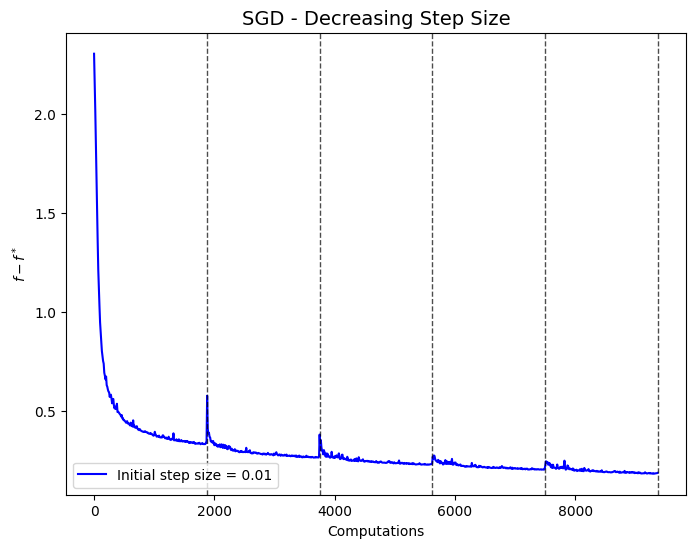

In [28]:
plt.figure(figsize=(8, 6))

# Define learning rate and batch size
learning_rate = 0.01
batch_size = 32
epochs = 5

model = build_model()

# Run SGD with multiple epochs
loss_list, n_computation = SGD(model, x_train, y_train, learning_rate, epochs=epochs, batch_size=batch_size)

plt.plot(n_computation, loss_list, label=f"Initial step size = {learning_rate}", color="blue")

# Total batches in one epoch
num_batches_per_epoch = x_train.shape[0] // batch_size

for epoch in range(1, epochs + 1):
    plt.axvline(x=epoch * num_batches_per_epoch, color='black', linestyle="--", linewidth=1, alpha=0.7)

plt.xlabel("Computations")
plt.ylabel(r"$f - f^*$")
plt.title("SGD - Decreasing Step Size", fontsize=14)
plt.legend()

plt.show()

# Evaluation of the model

#### **Question 7.1: Evaluate the accuracy of the models on the training set and on the test set. Compare the different methods.**